In [1]:
import pandas as pd
from pathlib import Path
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import csv
import shutil
from collections import Counter
import numpy as np
import tensorflow as tf
import keras
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import matplotlib.pyplot as plt
import seaborn as sb
import cv2
import sklearn
from random import shuffle
from keras.layers import *
from keras.models import Model
from keras import backend as K
from tensorflow import losses, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm import tqdm

2024-11-24 15:01:56.797345: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-24 15:01:56.815425: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-24 15:01:56.820341: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-24 15:01:56.834440: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the a

In [2]:
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   # Create 2 virtual GPUs with 1GB memory each
#   try:
#     tf.config.set_logical_device_configuration(
#         gpus[0],
#         [tf.config.LogicalDeviceConfiguration(memory_limit=30720),
#          tf.config.LogicalDeviceConfiguration(memory_limit=10384)])
#     logical_gpus = tf.config.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Virtual devices must be set before GPUs have been initialized
#     print(e)

# logical_gpus = tf.config.list_logical_devices('GPU')
# print("Num Logical GPUs Available: ", len(logical_gpus))

1 Physical GPU, 2 Logical GPUs


I0000 00:00:1732481917.257143    9587 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732481917.315227    9587 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732481917.315324    9587 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732481917.335148    9587 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732481917.335362    9587 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1732482144.681753   10251 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732482144.740517   10251 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732482144.740593   10251 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732482144.754254   10251 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732482144.754322   10251 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [32]:
# Define the path where the images are located and where we want to create the class directories
image_folder = '/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/trail/images'
csv_file = '/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/trail/labels_trail.csv'

# Read the CSV file using pandas
df = pd.read_csv(csv_file)

# Extract the class labels from the CSV file
# Assuming the first 4 columns are headers, and the next 3 rows correspond to the images
classes = df.iloc[0:, 5:].values  # The class names for each image (after the header row)
# List of class names (from the CSV structure)
# Find unique values in the 'column_name' column
class_names = df['label'].unique()

# Ensure that class directories exist
for class_name in class_names:
    class_dir = os.path.join(image_folder, class_name)
    if not os.path.exists(class_dir):
        os.makedirs(class_dir)

# Loop over all images 
for i in range(3):  # 3 rows for 10 images each
    for j in range(10):  # 10 images per row
        image_filename = f"{i}_{j}.jpg"  # Assuming images are named like 0_0.jpg, 0_1.jpg, etc.
        image_path = os.path.join(image_folder, image_filename)

        # Find the class for this image based on the CSV
        class_label = classes[i][0]
        #print(class_label)
        
        # Determine the target class directory
        target_dir = os.path.join(image_folder, class_label)

        # Move the image to the correct class directory
        if os.path.exists(image_path):
            shutil.move(image_path, os.path.join(target_dir, image_filename))
        else:
            print(f"Warning: {image_filename} not found in {image_folder}")

print("Images have been successfully organized.")

Images have been successfully organized.


In [37]:
# Read the CSV file
df = pd.read_csv("/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/trail/labels_trial.csv")

# Find unique values in the 'column_name' column
unique_values = df['label'].unique()

print(len(unique_values))
print(unique_values)

3
['metamyelocyte' 'myelocyte' 'seg_neutrophil']


In [5]:
# set some paths
model_dir = Path('bin')
DATA_DIR = Path('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/trail/images')
DATA_DIR_seg_neutrophil = Path('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/trail/images/seg_neutrophil')
DATA_DIR_band_neutrophil = Path('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/trail/images/band_neutrophil')
DATA_DIR_lymphocyte = Path('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/trail/images/lymphocyte')


# set some variables 
label_names =  {'seg_neutrophil': 0, 'band_neutrophil': 1, 'lymphocyte': 2}

In [38]:
def create_dataset(img_folder):
    img_data_array=[]
    class_name=[]
   
    for dir_name in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir_name)):
       
            image_path= os.path.join(img_folder, dir_name,  file)
            image= cv2.imread(image_path)[:,:,::-1]
            image=cv2.resize(image, (192, 192),interpolation = cv2.INTER_AREA)   
            # image [image<0] = 0
            img_nor = image / np.max(image)
            image=np.array(img_nor, dtype = np.float32)
            
            img_data_array.append(image)
            class_name.append(dir_name)
    return img_data_array, class_name


## extract the image array and class name
# X_metamyelocyte, y_metamyelocyte = create_dataset(DATA_DIR_metamyelocyte)
# X_myelocyte, y_myelocyte = create_dataset(DATA_DIR_myelocyte)
# X_seg_neutrophil, y_seg_neutrophil = create_dataset(DATA_DIR_seg_neutrophil)
# X_band_neutrophil, y_band_neutrophil = create_dataset(DATA_DIR_band_neutrophil)
# X_lymphocyte, y_lymphocyte = create_dataset(DATA_DIR_lymphocyte)

X1, y1 =create_dataset(r'/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/trail/images')

In [81]:
def create_dataset(img_folder):
    #img_data_array=[]
    class_name=[]   
    stacked_images = []
    image_batch = []
    for dir_name in os.listdir(img_folder):  
        for file in os.listdir(os.path.join(img_folder, dir_name)):
            image_path= os.path.join(img_folder, dir_name,  file)
            image= cv2.imread(image_path)[:,:,::-1]
            image=cv2.resize(image, (192, 192),interpolation = cv2.INTER_AREA)   
            # image [image<0] = 0
            img_nor = image / np.max(image)
            image=np.array(img_nor, dtype = np.float32)
            image_batch.append(image)
            if len(image_batch) == 10:  ##stack_size=10
                #stacked_image = np.concatenate(image_batch, axis=-1)  # Stack vertically
                stacked_images.append(image_batch)
                class_name.append(dir_name)
                image_batch = []               
    #images = np.array(stacked_images, np.float32)
    return stacked_images, class_name


## extract the image array and class name
# X_metamyelocyte, y_metamyelocyte = create_dataset(DATA_DIR_metamyelocyte)
# X_myelocyte, y_myelocyte = create_dataset(DATA_DIR_myelocyte)
# X_seg_neutrophil, y_seg_neutrophil = create_dataset(DATA_DIR_seg_neutrophil)
# X_band_neutrophil, y_band_neutrophil = create_dataset(DATA_DIR_band_neutrophil)
# X_lymphocyte, y_lymphocyte = create_dataset(DATA_DIR_lymphocyte)

x_meta, y_meta = create_dataset(r'/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/trail/images/metamyelocyte')
x_mye, y_mye = create_dataset(r'/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/trail/images/myelocyte')
x_seg, y_seg = create_dataset(r'/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/trail/images/seg_neutrophil')

In [86]:
chunk_size = 1
result = []

for i in tqdm(range(0, len(x_train), chunk_size)):
    chunk = x_train[i:i + chunk_size]
    result.append(np.array(chunk, np.float32))

final_array = np.concatenate(result)

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 942.47it/s]


In [112]:
def create_dataset(img_folder):
    
    stacked_images = []
    image_batch = []  
    for file in os.listdir(img_folder):
        image_path= os.path.join(img_folder, file)
        image= cv2.imread(image_path)[:,:,::-1]
        image=cv2.resize(image, (192, 192),interpolation = cv2.INTER_AREA)   
        # image [image<0] = 0
        img_nor = image / np.max(image)
        image=np.array(img_nor, dtype = np.float32)
        image_batch.append(image)
        if len(image_batch) == 10:  ##stack_size=10
            #stacked_image = np.concatenate(image_batch, axis=-1)  # Stack vertically
            stacked_images.append(image_batch)
            image_batch = []               
    return stacked_images


## extract the image array and class name
# X_metamyelocyte, y_metamyelocyte = create_dataset(DATA_DIR_metamyelocyte)
# X_myelocyte, y_myelocyte = create_dataset(DATA_DIR_myelocyte)
# X_seg_neutrophil, y_seg_neutrophil = create_dataset(DATA_DIR_seg_neutrophil)
# X_band_neutrophil, y_band_neutrophil = create_dataset(DATA_DIR_band_neutrophil)
# X_lymphocyte, y_lymphocyte = create_dataset(DATA_DIR_lymphocyte)

x_meta = create_dataset(r'/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/trail/images/metamyelocyte')
x_mye = create_dataset(r'/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/trail/images/myelocyte')
x_seg = create_dataset(r'/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/trail/images/seg_neutrophil')

In [113]:
len(x_seg)

1

In [118]:
chunk_size = 1
result = []

for i in tqdm(range(0, len(x_meta), chunk_size)):
    chunk = x_meta[i:i + chunk_size]
    result.append(np.array(chunk, np.float32))

final_array = np.concatenate(result)

100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 769.17it/s]


In [119]:
split_images = final_array.reshape(-1, 192, 192, 3)

# Verify the shape of the result
print(split_images.shape)  # This should output (30, 192, 192, 3)

(10, 192, 192, 3)


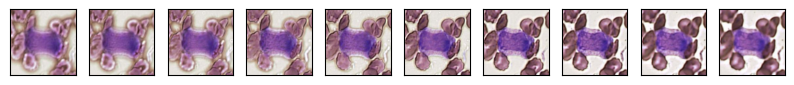

In [120]:
### Visualize the Dataset
plt.figure(figsize=(10,9))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow((split_images[i] * 255).astype(np.uint8))
plt.show()

In [92]:
chunk_size = 1
result = []

for i in tqdm(range(0, len(x_meta), chunk_size)):
    chunk = x_train[i:i + chunk_size]
    result.append(np.array(chunk, np.float32))

final_array = np.concatenate(result)

100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 828.67it/s]


In [93]:
final_array.shape

(2, 10, 192, 192, 3)

In [89]:
array = np.full(10, 2, dtype=np.float32)

print(array)

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


In [84]:
final_array.shape

(3, 10, 192, 192, 3)

In [70]:
target_dict1={k: v for v, k in enumerate(np.unique(y1))}
target_val1=  [target_dict1[y1[i]] for i in range(len(y1))]
print(target_dict1)

{np.str_('metamyelocyte'): 0, np.str_('myelocyte'): 1, np.str_('seg_neutrophil'): 2}


In [87]:
y_train

array([0., 1., 2.], dtype=float32)

In [55]:
## For Training Set ##
y_train=np.array(list(map(int,target_val1)), np.float32)

In [58]:
y_train.shape

(3,)

In [72]:
x_train.shape

(3, 10, 192, 192, 3)

In [76]:
x_train.shape

(3, 10, 192, 192, 3)

In [77]:
split_images = image_array.reshape(-1, 192, 192, 3)

# Verify the shape of the result
print(split_images.shape)  # This should output (30, 192, 192, 3)

(30, 192, 192, 3)


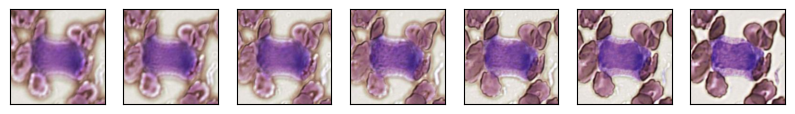

In [79]:
### Visualize the Dataset
plt.figure(figsize=(10,9))
for i in range(7):
    plt.subplot(1,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow((split_images[i] * 255).astype(np.uint8))
plt.show()

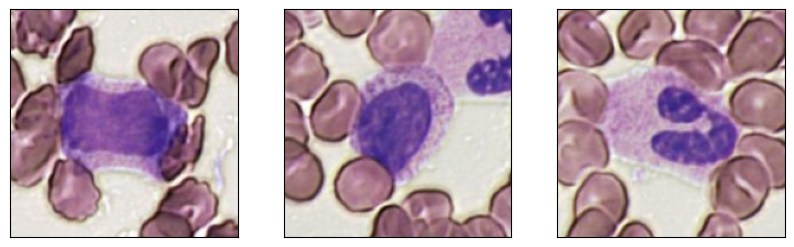

In [64]:
### Visualize the Dataset
plt.figure(figsize=(10,9))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow((x_train[i][5] * 255).astype(np.uint8))
plt.show()

In [62]:
gamma = [.60, .80, 1.10]

img_aug_array= []
LM_aug_array = []

for d in tqdm(range (x_train.shape[0])):
    for e in range (3):
            volume = np.power(x_train[d], gamma[e]) 
            img_aug_array.append(volume)
            LM = y_train[d]
            LM_aug_array.append(LM)
        
x_aug1 = np.array(img_aug_array, np.float32)
#X_aug1 = np.expand_dims(X_aug1, axis=3)
print(x_aug1.shape)
y_aug1 = np.array(LM_aug_array, np.float32)
print(y_aug1.shape)

100%|███████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 1999.93it/s]

(93, 192, 192, 3)
(93,)


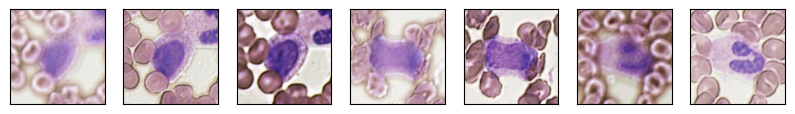

In [76]:
### Visualize the Dataset
plt.figure(figsize=(10,9))
for i in range(7):
    plt.subplot(1,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_aug1[i*13])
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 22.60it/s]


(372, 192, 192, 3)
(372,)


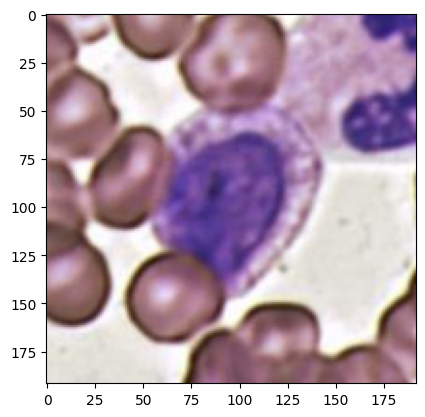

In [77]:
from scipy.ndimage import rotate

angles = np.arange(-90, 90, 15)
img_aug_array= []
label_array = []

for d in tqdm(range(x_train.shape[0])): 
    for e in range (12):
            volume = rotate(x_train[d], angles[e], reshape=False, order=1) 
            img_aug_array.append(volume)
            label = y_train[d]
            label_array.append(label)
        
x_aug2 = np.array(img_aug_array, np.float32)
print(X_aug2.shape)
y_aug2 = np.array(label_array, np.float32)
print(y_aug2.shape)

plt_case = 102
plt.imshow(x_aug2[plt_case])

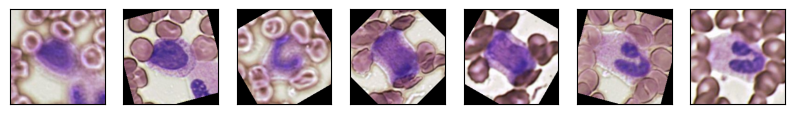

In [73]:
### Visualize the Dataset
plt.figure(figsize=(10,9))
for i in range(7):
    plt.subplot(1,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow((x_aug2[i*61] * 255).astype(np.uint8))
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 203.10it/s]

(62, 192, 192, 3)
(62,)


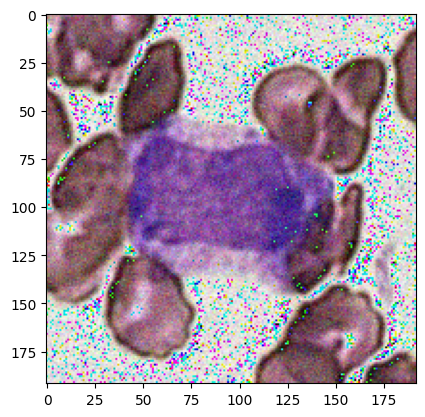

In [120]:
def Gaussian(image, noise):
    row,col,ch= image.shape
    mean = 1
    sigma = noise # (1-2)e-2
    gauss = np.random.normal(mean,sigma,(row,col, ch))
    gauss = gauss.reshape(row,col, ch)
    noisy = image + gauss
    return noisy

img_aug_array=[]
label_array = []
noises = [6e-2, 7e-2] ##higher value adds more noise [2e-3, 3e-3, 4e-3, 5e-3, 6e-3]
for d in tqdm(range(x_train.shape[0])):
    for e in range (2):
            volume = Gaussian(x_train[d], noise = noises[e])
            img_aug_array.append(volume)
            label = y_train[d]
            label_array.append(label)
        
x_aug3 = np.array(img_aug_array, np.float32)
print(X_aug3.shape)
y_aug3 = np.array(label_array, np.float32)
print(y_aug3.shape)
#################################################################

plt_case = 35
#plt.imshow(x_aug3[plt_case])
plt.imshow((x_aug3[plt_case] * 255).astype(np.uint8))

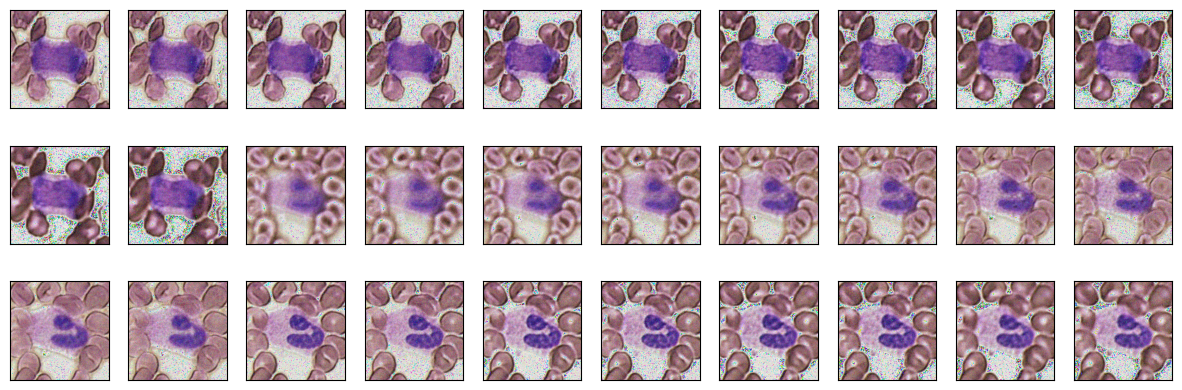

In [107]:
### Visualize the Dataset
plt.figure(figsize=(15,5))
for i in range(30):
    plt.subplot(3,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow((x_aug3[i+30] * 255).astype(np.uint8))
plt.show()

In [144]:
x_aug = np.concatenate((x_aug1, x_aug2, x_aug3))
print(x_aug.shape)
y_aug = np.concatenate((y_aug1, y_aug2, y_aug3))
print(y_aug.shape)

(527, 192, 192, 3)
(527,)


In [3]:
def create_dataset(img_folder, label):
    stacked_images = []
    image_batch = []  
    for file in tqdm(os.listdir(img_folder)):
        image_path= os.path.join(img_folder, file)
        image= cv2.imread(image_path)[:,:,::-1]
        image=cv2.resize(image, (128, 128),interpolation = cv2.INTER_AREA)   
        # image [image<0] = 0
        img_nor = image / 255.0  ##np.max(image)
        image=np.array(img_nor, dtype = np.float32)
        image_batch.append(image)
        if len(image_batch) == 10:  ##stack_size=10
            #stacked_images.append(image_batch)
            stacked_images.append(np.array(image_batch, np.float32))
            image_batch = []          
    stacked_images = np.array((stacked_images), np.float32)
    train, test, = train_test_split(stacked_images, test_size=0.1, random_state=7)
    train_images = train.reshape(-1, 128, 128, 3)
    train_label = np.full(len(train_images), label)
    test_images = test.reshape(-1, 128, 128, 3)
    test_label = np.full(len(test_images), label)
    return train_images, train_label, test_images, test_label

def complete_data(full_datapath):
    label = 0
    for dir_name in os.listdir(full_datapath):
        data_path = os.path.join(full_datapath, dir_name)
        #print(data_path)
        print(f"class {label} is associated with directory: {dir_name}")
        train_images, train_label, test_images, test_label = create_dataset(data_path, label)
        label+=1
        if label == 1:
            train_data = train_images
            train_class = train_label
            test_data = test_images
            test_class = test_label
        else:
            train_data = np.concatenate((train_data, train_images))
            train_class = np.concatenate((train_class, train_label))
            test_data = np.concatenate((test_data, test_images))
            test_class = np.concatenate((test_class, test_label))
            del train_images
            del train_label
            del test_images
            del test_label
    return train_data, train_class, test_data, test_class
    
x_train, y_train, x_test, y_test = complete_data(r'/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/unused class')
print(f"x_training data shape: {x_train.shape} and test data shape: {x_test.shape}: ")
print(f"x_training label shape: {y_train.shape} and test label shape: {y_test.shape}: ")

class 0 is associated with directory: artifact


100%|███████████████████████████████████████████████████████████████████████████████| 3490/3490 [01:53<00:00, 30.82it/s]


class 1 is associated with directory: promyelocyte


100%|█████████████████████████████████████████████████████████████████████████████████| 240/240 [00:07<00:00, 31.64it/s]


class 2 is associated with directory: unk_wbc


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.76it/s]


x_training data shape: (3370, 128, 128, 3) and test data shape: (390, 128, 128, 3): 
x_training label shape: (3370,) and test label shape: (390,): 


In [4]:
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

print(y_train_encoded.shape)
print(y_test_encoded.shape)

(3370, 3)
(390, 3)


In [11]:
# np.save('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/train_data.npy', x_train)
# np.save('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/train_label.npy', y_train_encoded)
# np.save('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/test_data.npy', x_test)
# np.save('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/test_label.npy', y_test_encoded)

In [3]:
x_train = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/train_data.npy')
y_train_encoded = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/train_label.npy')
x_test = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/test_data.npy')
y_test_encoded = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/test_label.npy')

In [8]:
def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True):
    if conv_shortcut:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(x)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = x

    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([shortcut, x])
    x = ReLU()(x)

    return x
    
def resnet_34(input_shape=(128, 128, 3), num_classes=3):
    inputs = Input(shape=input_shape)

    # Initial Conv
    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Residual blocks
    for size in [64, 128, 256, 512]:
        strides = 1 if size == 64 else 2
        x = residual_block(x, size, stride=strides)
        for _ in range(1, (34-2)//6 if size == 64 else 2):
            x = residual_block(x, size, conv_shortcut=False)

    # Global Average Pooling and Fully Connected Layer
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return tf.keras.models.Model(inputs=inputs, outputs=outputs)

model = resnet_34()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 32, 32,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat

 Total params: 11,419,971 (43.56 MB)

 Trainable params: 11,409,475 (43.52 MB)

 Non-trainable params: 10,496 (41.00 KB)

In [7]:
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip((y_true) * (y_pred), 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives/(possible_positives + K.epsilon())
    
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1))) 
    return true_negatives / (possible_negatives + K.epsilon())

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
    return lr

class EvaluateCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss, accuracy = self.model.evaluate(x_test, y_test_encoded, verbose=1, batch_size=20)
        print(f'Epoch {epoch+1}: Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}')

In [9]:
LR = 0.001
lr_schedule = optimizers.schedules.ExponentialDecay(initial_learning_rate=LR,decay_steps=5000,decay_rate=0.5) #should be<1, or lr rate incrs
optim = optimizers.Adam(learning_rate=lr_schedule)
lr_metric = get_lr_metric(optim)
model.compile(optimizer=optim, loss = 'categorical_crossentropy', metrics=['accuracy'])
loss, acc = model.evaluate(x_test, y_test_encoded, batch_size=20)
print(f"test loss: {loss}, test acc: {acc}")

I0000 00:00:1732482500.104702   10446 service.cc:146] XLA service 0x7f6f4000a610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732482500.105380   10446 service.cc:154]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2024-11-24 15:08:20.156034: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-24 15:08:20.510178: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


12/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 1.1081

I0000 00:00:1732482504.600180   10446 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.0124 - loss: 1.1075
test loss: 1.1050376892089844, test acc: 0.07692307978868484


In [10]:
val_loss = []
val_acc = []
# loss= []
# acc= []
for i in range(5):
    #model = resnet_34()
    LR = 0.001
    lr_schedule = optimizers.schedules.ExponentialDecay(initial_learning_rate=LR,decay_steps=5000,decay_rate=0.5) #should be<1, or lr rate incrs
    optim = optimizers.Adam(learning_rate=lr_schedule)
    lr_metric = get_lr_metric(optim)
    
    filepath = '/mnt/c/Users/Dhruba/Codes/saved models/WBC_RS34.ep{epoch:02d}-loss_{loss:.2f}-acc_{accuracy:.3f}.keras'
    checkpoint = ModelCheckpoint(filepath=filepath, monitor='loss',verbose=1, save_best_only=True, mode='min')
    evaluate_callback = EvaluateCallback()
    
    model.compile(optimizer=optim, loss = 'categorical_crossentropy', metrics=['accuracy'])
    model.fit(x=x_train,
                y=y_train_encoded,
                batch_size = 40,
                epochs = 1,
                verbose=1,
                #validation_split=0.2,
                validation_data=None #(x_test, y_test_encoded),
                #callbacks=[checkpoint]
                #class_weight = class_weightx,
              )
    
    loss, acc = model.evaluate(x_test, y_test_encoded, batch_size=20)
    print(f"test loss: {loss}, test acc: {acc}")

 ### for plot later ###

val_loss.append(loss)
val_acc.append(acc)

# l, a = model.evaluate(x=x_train, y=y_train_encoded)
# loss.append(l)
# acc.append(a)
    
print("/n/n Done with training")

2024-11-24 15:08:54.090896: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7783', 4 bytes spill stores, 4 bytes spill loads



85/85 ━━━━━━━━━━━━━━━━━━━━ 43s 200ms/step - accuracy: 0.8846 - loss: 0.3144
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.9185 - loss: 0.5412
test loss: 2.9056344032287598, test acc: 0.8358974456787109
85/85 ━━━━━━━━━━━━━━━━━━━━ 35s 164ms/step - accuracy: 0.8891 - loss: 0.3093
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.9851 - loss: 0.3166  
test loss: 2.178269386291504, test acc: 0.8974359035491943
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 172ms/step - accuracy: 0.9008 - loss: 0.3876
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.8942 - loss: 0.6638
test loss: 2.329850196838379, test acc: 0.8153846263885498
85/85 ━━━━━━━━━━━━━━━━━━━━ 34s 162ms/step - accuracy: 0.9104 - loss: 0.4317
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.9851 - loss: 0.5253  
test loss: 3.445013999938965, test acc: 0.8974359035491943
82/85 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8829 - loss: 0.5012

KeyboardInterrupt: 

In [ ]:
LR = 0.001
lr_schedule = optimizers.schedules.ExponentialDecay(initial_learning_rate=LR,decay_steps=5000,decay_rate=0.5) #should be < 1, otherwise lr rate incrs

optim = optimizers.Adam(learning_rate=lr_schedule)
lr_metric = get_lr_metric(optim)


model.compile(optimizer=optim, loss = 'categorical_crossentropy', metrics=['accuracy'])
filepath = '/mnt/c/Users/Dhruba/Codes/saved models/WBC_RS34.ep{epoch:02d}-loss_{loss:.2f}-acc_{accuracy:.3f}.keras'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
#callbacks = [checkpoint]

# class_weightx = {0: 1.,
#                 1: 5.,
#                 2: 1}


# Create an instance of the callback
evaluate_callback = EvaluateCallback()


result = model.fit(x=x_train,
                    y=y_train_encoded,
                    batch_size = 40,
                    epochs = 5,
                    verbose=1,
                    #validation_split=0.2,
                    validation_data=None, #(x_test, y_test_encoded),
                    callbacks=[evaluate_callback, checkpoint]
                    #class_weight = class_weightx,
                  )

In [11]:
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip((y_true) * (y_pred), 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives/(possible_positives + K.epsilon())
    
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1))) 
    return true_negatives / (possible_negatives + K.epsilon())

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
    return lr
    
LR = 0.001
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LR,
    decay_steps=10000,
    decay_rate=0.1) #should be < 1, otherwise lr rate increases

optim = optimizers.Adam(learning_rate=lr_schedule)
lr_metric = get_lr_metric(optim)


model.compile(optimizer=optim, loss = 'categorical_crossentropy', metrics=['accuracy'])  ##if not one-hot encoded use: SparseCategoricalCrossentropy
filepath = '/mnt/c/Users/Dhruba/Codes/saved models/WBC_RS34.ep{epoch:02d}-loss_{loss:.2f}-acc_{accuracy:.2f}.keras'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
#callbacks = [checkpoint]

class EvaluateCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss, accuracy = self.model.evaluate(x_test, y_test_encoded, verbose=1, batch_size=10)
        print(f'Epoch {epoch+1}: Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}')

# Create an instance of the callback
evaluate_callback = EvaluateCallback()

# class_weightx = {0: 1.,
#                 1: 5.,
#                 2: 1}

result = model.fit(x=x_train,
                    y=y_train_encoded,
                    batch_size = 40,
                    epochs = 2,
                    verbose = 1,
                    #validation_split=0.2,
                    validation_data = None,# (x_test, y_test_encoded),
                    #validation_batch_size = 80,
                    callbacks=[evaluate_callback, checkpoint],
                    #class_weight = class_weightx,
                    shuffle=True)

Epoch 1/2
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7993 - loss: 0.9954
Epoch 1: Test loss: 1.726, Test accuracy: 0.705

Epoch 1: loss improved from inf to 0.08699, saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_RS34.ep01-loss_0.09-acc_0.97.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 41s 242ms/step - accuracy: 0.9627 - loss: 0.1411
Epoch 2/2
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9412 - loss: 0.3100
Epoch 2: Test loss: 0.314, Test accuracy: 0.923

Epoch 2: loss improved from 0.08699 to 0.00655, saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_RS34.ep02-loss_0.01-acc_1.00.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.9973 - loss: 0.0106


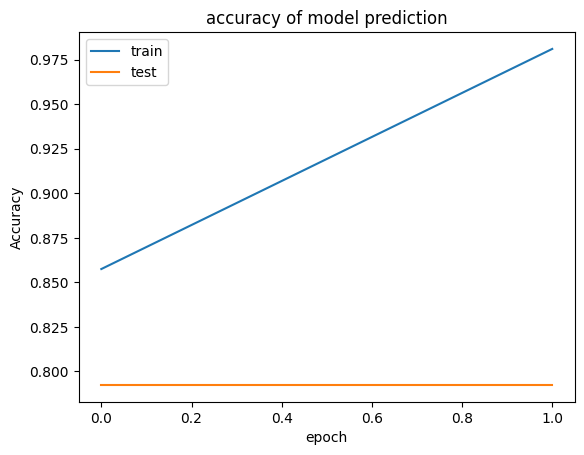

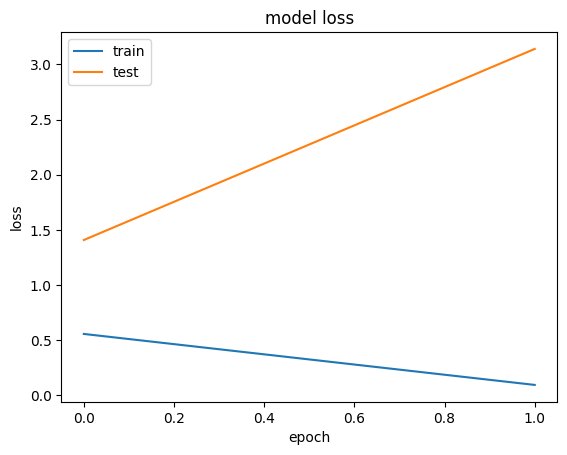

In [154]:
# list all data in history
# summarize history for loss
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('accuracy of model prediction')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# plt.plot(result.history['specificity'])
# plt.plot(result.history['val_specificity'])
# plt.title('model specificity_metric')
# plt.ylabel('specificity_metric')
# plt.xlabel('epoch')
# plt.legend(['train','test'], loc='upper left')
# plt.show()

In [21]:
# #import tensorflow.keras.backend as K

# def dense_block(x, repetitions, filters):
#     for _ in range(repetitions):
#         y = BatchNormalization()(x)
#         y = ReLU()(y)
#         y = Conv2D(4 * filters, 1, padding='same')(y)
#         y = BatchNormalization()(y)
#         y = ReLU()(y)
#         y = Conv2D(filters, 3, padding='same')(y)
#         x = concatenate([y, x])
#     return x

# def transition_layer(x):
#     x = BatchNormalization()(x)
#     x = ReLU()(x)
#     x = Conv2D(K.int_shape(x)[-1] // 2, 1, padding='same')(x)
#     x = AvgPool2D(2, strides=2, padding='same')(x)
#     return x

# def DenseNet121(input_shape=(128, 128, 3), num_classes=3):
#     inputs = Input(input_shape)

#     x = Conv2D(64, 7, strides=2, padding='same')(inputs)
#     x = BatchNormalization()(x)
#     x = ReLU()(x)
#     x = MaxPool2D(3, strides=2, padding='same')(x)

#     x = dense_block(x, 6, 32)
#     x = transition_layer(x)

#     x = dense_block(x, 12, 32)
#     x = transition_layer(x)

#     x = dense_block(x, 24, 32)
#     x = transition_layer(x)

#     x = dense_block(x, 16, 32)

#     x = GlobalAveragePooling2D()(x)
#     outputs = Dense(num_classes, activation='softmax')(x)

#     model = Model(inputs, outputs)
#     return model

# model = DenseNet121()
# model.summary()

In [8]:
# import multiprocessing

# def train_and_evaluate():
#     def get_lr_metric(optimizer):
#         def lr(y_true, y_pred):
#             return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
#         return lr
#     # Build and train a Keras model with the given params
#     LR = 0.0005
#     lr_schedule = optimizers.schedules.ExponentialDecay(
#         initial_learning_rate=LR,
#         decay_steps=5000,
#         decay_rate=0.2) #should be < 1, otherwise lr rate increases
#     optim = optimizers.Adam(learning_rate=lr_schedule)
#     lr_metric = get_lr_metric(optim)
    
#     model.compile(optimizer=optim, loss = 'categorical_crossentropy', metrics=['accuracy'])
#     filepath = '/mnt/c/Users/Dhruba/Codes/saved models/WBC_RS34.ep{epoch:02d}-loss_{loss:.2f}-acc_{accuracy:.3f}.keras'
#     checkpoint = ModelCheckpoint(filepath=filepath, 
#                                  monitor='val_loss',
#                                  verbose=1, 
#                                  save_best_only=True,
#                                  mode='min')
#     callbacks = [checkpoint]
#     result = model.fit(x=x_train,
#                         y=y_train_encoded,
#                         batch_size = 80,
#                         epochs = 5,
#                         verbose=1,
#                         #validation_split=0.2,
#                         validation_data=None, #(x_test, y_test_encoded),
#                         callbacks=callbacks,
#                         #class_weight = class_weightx,
#                         shuffle=True)
#     return model.evaluate(x_test, y_test_encoded, batch_size=40, verbose=1)

#     pool = multiprocessing.Pool()
#     results = pool.map(train_and_evaluate)
#     pool.close()
#     pool.join()

In [9]:
A = train_and_evaluate()

Epoch 1/5


I0000 00:00:1732461064.576896   23437 service.cc:146] XLA service 0x7f2ee0002ea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732461064.576954   23437 service.cc:154]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2024-11-24 09:11:04.945779: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-24 09:11:06.539615: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-11-24 09:11:08.443189: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7966', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1732461082.197170   23437 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


43/43 ━━━━━━━━━━━━━━━━━━━━ 47s 423ms/step - accuracy: 0.8083 - loss: 0.6209
Epoch 2/5


/root/miniconda3/envs/tff/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9899 - loss: 0.0263
Epoch 3/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9996 - loss: 0.0030
Epoch 4/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 1.0000 - loss: 7.5905e-04
Epoch 5/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 1.0000 - loss: 9.6095e-05


2024-11-24 09:11:47.042533: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_731', 4 bytes spill stores, 4 bytes spill loads



10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 294ms/step - accuracy: 0.9788 - loss: 0.2313 
